In [1]:
import time
from tqdm import tqdm
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import os
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import time
import warnings

In [2]:
# Load the data
df = pd.read_csv('Data/train_essays/train_essays.csv')

# Display the data
df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [3]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Drop the last column from the test data
test_df = test_df.iloc[:, :-1]

# Create a directory to save the temporary data
os.makedirs('Data/temporary', exist_ok=True)

# Save the training and testing data
train_df.to_csv('Data/temporary/Temp_Train_Data.csv', index=False) #change the path according to kaggel
test_df.to_csv('Data/temporary/Temp_Test_Data.csv', index=False) #change the path according to kaggel

In [4]:
# Load the training and testing data
train_df = pd.read_csv('Data/temporary/Temp_Train_Data.csv') #change the path according to kaggel
test_df = pd.read_csv('Data/temporary/Temp_Test_Data.csv') #change the path according to kaggel


In [5]:
# Display the training data
train_df

,id,prompt_id,text,generated
0,e0dbb2e7,0,"Cars, they make life so much easier, or, do th...",0
1,3d75a33b,0,Now a days you see everyone with cars driving ...,0
2,6049a24f,1,Presidential election is held every after four...,0
3,cecf6e5e,1,I dont think that the electoral college should...,0
4,669e6f61,0,How could we get the reduction of Greenhouse G...,0
...,...,...,...,...
1097,c7c1cf69,0,People all over the world are saying goodbye t...,0
1098,cf8af518,1,"Dear state senator, I believe that we shouldn'...",0
1099,f01dd0a6,0,The modern automobile has been the axle to the...,0
1100,9b753df1,1,The Electoral College is a process that should...,0


In [6]:
# Display the testing data
test_df

,id,prompt_id,text
0,70d7c567,0,Can you imagine living in a place where there ...
1,81977e6c,0,Limiting car usage could have many advantages ...
2,e43869b8,0,"In this generation, our planet is getting filt..."
3,d33eca96,0,Cars are a basic need for people today we use ...
4,71f7131e,1,Why do we keep this despised method of choosin...
...,...,...,...
271,62b480e1,0,The culture of the car has been coming to an e...
272,7405b110,0,"Cars, though useful, have negative impacts on ..."
273,47e743a7,0,The extensive use of car transportation is set...
274,95d41c3e,0,Do you know what pollution is? Have you ever t...


In [7]:
# Define the function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokenizer = get_tokenizer('basic_english')
    words = tokenizer(text)
    return words

# Define a function to apply to the DataFrame


def preprocess_df(df):
    # Check if the 'text' column has already been tokenized
    if isinstance(df['text'][0], list):
        warnings.warn("The 'text' column has already been tokenized. Running this function again may lead to unexpected results.")
        return df['text']
    # If not, tokenize the 'text' column
    else:
        preprocessed_texts = df['text'].apply(preprocess_text)
        return preprocessed_texts

# Start the timer
start_time = time.time()

# Preprocess the text
df['text'] = preprocess_df(df)

# Build a vocabulary
vocab = build_vocab_from_iterator(df['text'].tolist(), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Convert words into numerical representations
df['text'] = df['text'].apply(lambda text: [vocab[word] for word in text])

# Define max_length as the length of the longest sequence
max_length = max(df['text'].apply(len))

# Pad the sequences
df['text'] = df['text'].apply(lambda x: x + [vocab["<unk>"]] * (max_length - len(x)) if len(x) < max_length else x[:max_length])

# Convert the list of sequences into a torch tensor
X = torch.tensor(df['text'].tolist())

# y is target variable
y = torch.tensor(df['generated'].tolist())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")

Elapsed time: 00:00:01.30


In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(f"X shape: {X.shape}")

X shape: torch.Size([1378, 1502])


In [10]:
print(f"Training data shape: {X_train.shape[0]}")
print(f"Test data shape: {X_test.shape[0]}")
print(f"Training labels shape: {y_train.shape[0]}")
print(f"Test labels shape: {y_test.shape[0]}")

Training data shape: 1102
Test data shape: 276
Training labels shape: 1102
Test labels shape: 276


In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [13]:
# Convert PyTorch tensors to numpy arrays
X_np = X.numpy()
y_np = y.numpy()

# Reshape X_np to be 3D (samples, timesteps, features)
X_np = X_np.reshape((X_np.shape[0], X_np.shape[1], 1))

# Define the model
from keras.layers import Bidirectional
# Get the sequence length and number of features from X
sequence_length, num_features = X_np.shape[1], X_np.shape[2]
print(f"Sequence length: {sequence_length}")
print(f"Number of features: {num_features}")
model_bidirectional = Sequential()
model_bidirectional.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(sequence_length, num_features)))
model_bidirectional.add(Dropout(0.2))
model_bidirectional.add(Bidirectional(LSTM(100)))
model_bidirectional.add(Dropout(0.2))
model_bidirectional.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bidirectional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model_bidirectional.fit(X_np, y_np, epochs=10, batch_size=64, validation_split=0.2)

Sequence length: 1502
Number of features: 1
Epoch 1/10
 1/18 [>.............................] - ETA: 1:19:36 - loss: 0.8040 - accuracy: 0.0312

In [ ]:
# Evaluate the model
loss, accuracy = model_bidirectional.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100}%')

9/9 [==============================] - 4s 474ms/step - loss: 0.0252 - accuracy: 0.9964
Accuracy: 99.63768124580383%


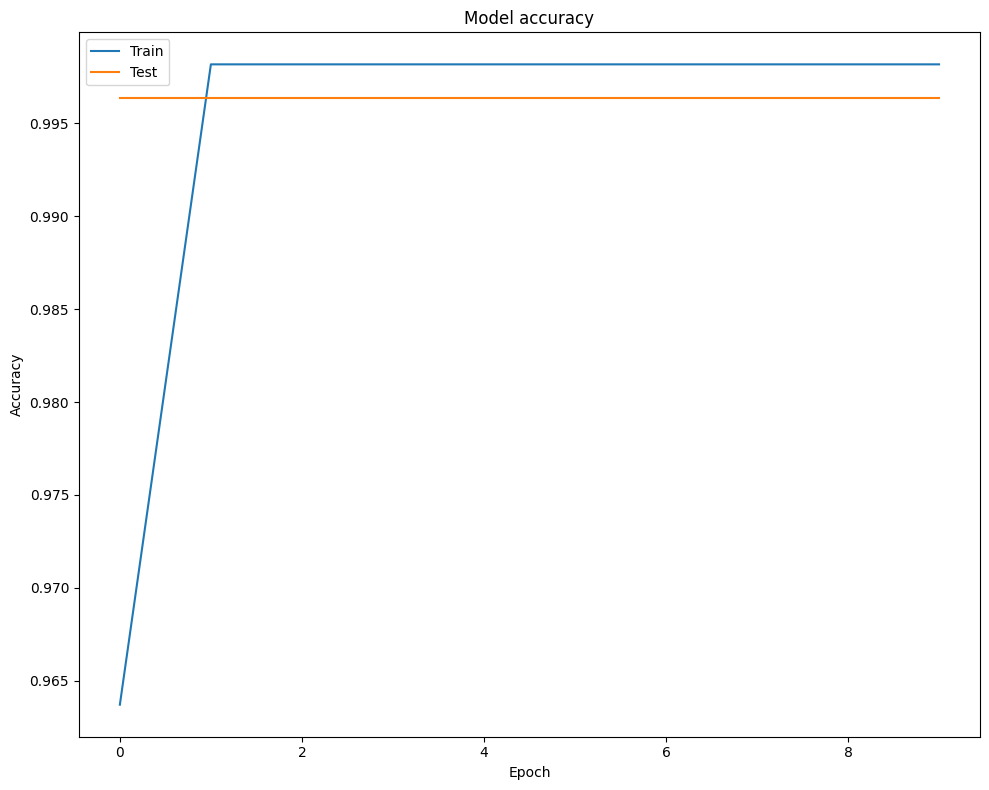

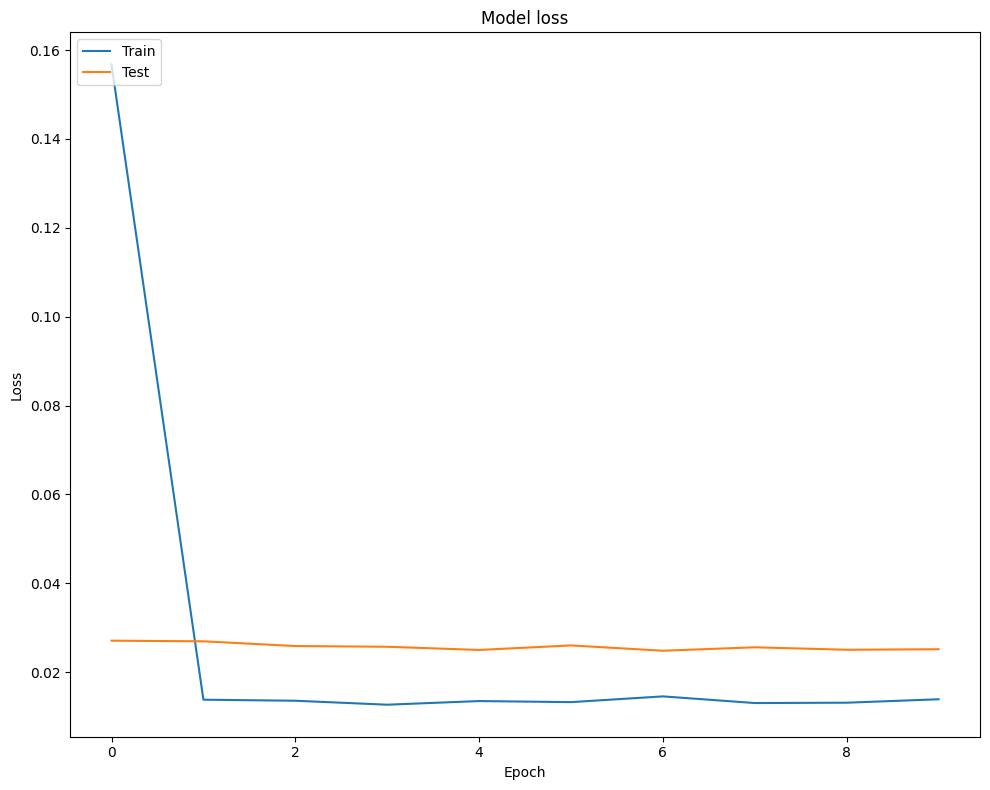

In [18]:
# Create the directories
os.makedirs('images/Recurrent Neural Network (RNN)', exist_ok=True)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/accuracy.png', dpi=600)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/loss.png', dpi=600)
plt.show()

In [19]:
# Save the model
model_rnn.save('my_model.h5') #change the path according to kaggel



C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Load the model
from keras.models import load_model
model = load_model('my_model.h5') #change the path according to kaggel

9/9 [==============================] - 3s 237ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      0.00      0.00         1

    accuracy                           1.00       276
   macro avg       1.00      0.50      0.50       276
weighted avg       1.00      1.00      0.99       276

ROC AUC: 0.5


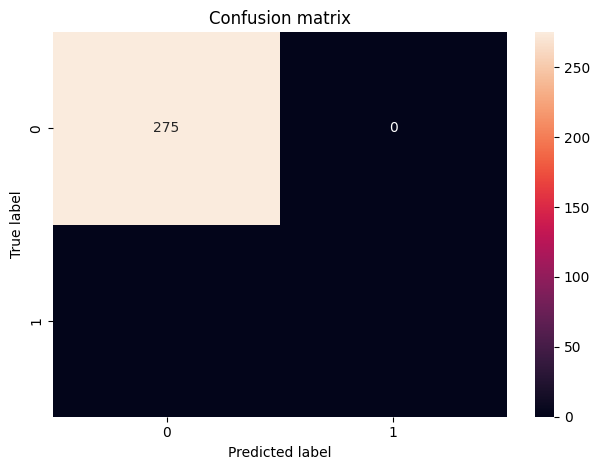

In [15]:
# X_test is the test data and y_test are the true labels
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary outputs

# Print the classification report
print(classification_report(y_test, y_pred, zero_division=1))

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/confusion_matrix.png', dpi=600)
plt.show()

In [13]:
# Create an array of IDs
ids = df['id'].values

# Split the IDs into training and test sets
_, ids_test = train_test_split(ids, test_size=0.2, random_state=42)

# Generate predictions
predictions = model.predict(X_test)

# If predictions is not a 1D array, flatten it
if predictions.ndim != 1:
    predictions = predictions.flatten()

# Create a new DataFrame with IDs and predictions
result_df = pd.DataFrame({
    'id': ids_test,
    'predictions': predictions
})

# Display the DataFrame
result_df

9/9 [==============================] - 2s 244ms/step


,id,predictions
0,70d7c567,0.001602
1,81977e6c,0.001467
2,e43869b8,0.001331
3,d33eca96,0.001379
4,71f7131e,0.002195
...,...,...
271,62b480e1,0.001516
272,7405b110,0.001500
273,47e743a7,0.001597
274,95d41c3e,0.001435
